# Homework 3
## Matthew Pronyshyn 1002365978

In [2]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import scipy.stats as stats

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/MatthewPronyshyn/STA365_Homework/main/hw3_data.csv")
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,Feature16,Feature17,Feature18,Feature19,Feature20
0,44.0,0.797417,-0.958091,NaN,NaN,158.0,1.490148,5.166124,2.277942,NaN,5,X,1,Category1,Option4,8.824345,11.711130,Yes,Low,NaN
1,47.0,0.026838,-0.244178,D,NaN,NaN,2.151535,0.450312,-3.395356,NaN,3,X,0,Category1,Option2,NaN,13.355832,Yes,Low,cat
2,64.0,0.199990,-1.014799,B,0.0,474.0,1.410613,6.786555,-3.070746,NaN,7,Z,0,Category1,Option2,NaN,13.449484,Yes,Medium,dog
3,67.0,0.474124,0.448040,B,NaN,166.0,0.635091,1.937158,-0.246269,6.004975,20,X,0,Category1,Option2,NaN,7.687652,Yes,Low,cat
4,NaN,0.598516,0.087839,NaN,0.0,NaN,0.392104,4.010937,3.215086,2.891199,3,Z,0,Category1,Option3,11.259371,6.807770,Yes,Low,cat


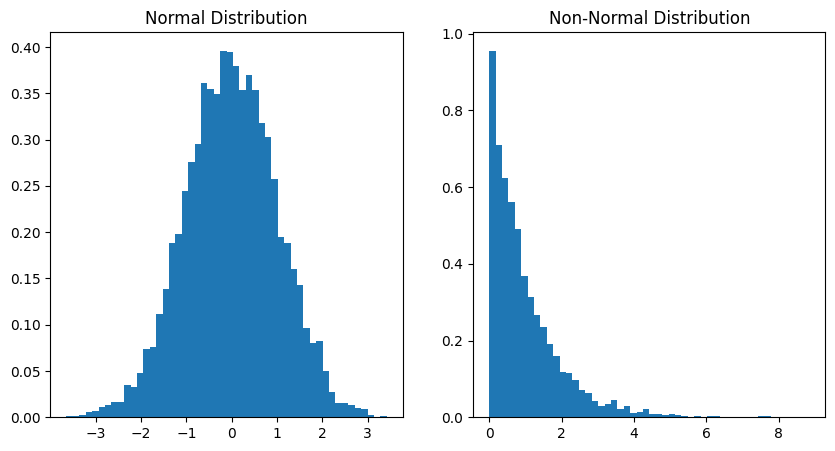

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(df["Feature3"],bins = 50,density=True)
ax[0].set_title("Normal Distribution")
ax[1].hist(df["Feature7"],bins = 50,density=True)
ax[1].set_title("Non-Normal Distribution")
plt.show()


In [5]:
normal_gamma_toy_model = pm.Model()
with normal_gamma_toy_model: 
    theta = pm.Normal("theta", mu=0, sigma=1)
    phi = pm.Gamma("phi", alpha=1, beta=1)
    x_obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed=df['Feature3'])

In [6]:
with normal_gamma_toy_model:
    idata_HMC = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


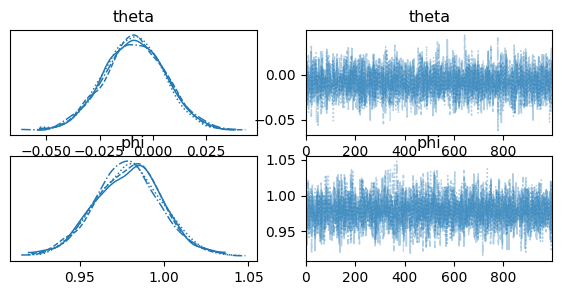

HMC Split-Rhats {'theta': 0.9997, 'phi': 1.0005} | 

In [7]:
fig,ax = plt.subplots(2,2, figsize=(7,3))
az.plot_trace(idata_HMC, axes=ax[:2,:2]); 
plt.show()
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | ');


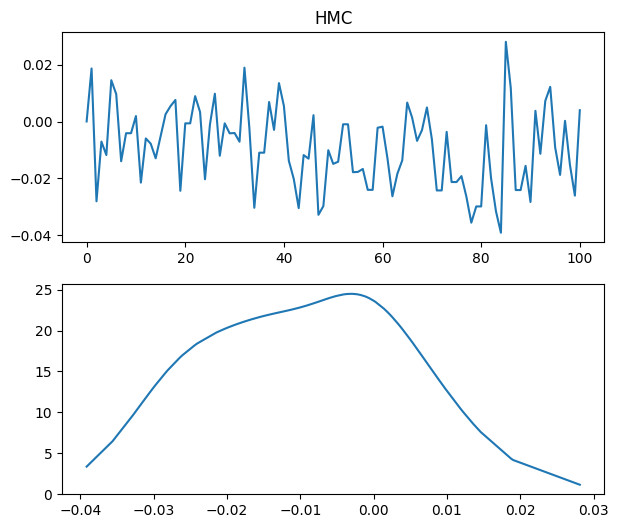

In [8]:
from scipy.stats import gaussian_kde; fig,ax = plt.subplots(2,1,figsize=(7,6))
n_mcmc_samples = 100
mcmc_chain = idata_HMC.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; 
mcmc_chain_sorted = sorted(mcmc_chain)
ax[0].plot(mcmc_chain); 
ax[1].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); 
ax[0].set_title("HMC");

Autocorrelation for HMC (MCMC) chain -0.023841838323138208


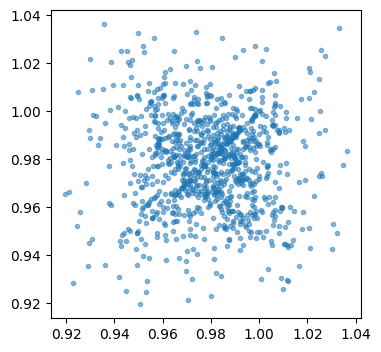

In [9]:
fig,ax = plt.subplots( figsize=(4,4))
max_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["phi"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; 
mcmc_chain_one_step_ahead = idata_HMC.posterior["phi"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; 
plt.plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])


In [10]:
print("number of MCMC samples:", idata_HMC.posterior['phi'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2)

number of MCMC samples: 4000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.01,0.01,-0.04,0.02,0.0,0.0,4169.99,3219.40,1.0
phi,0.98,0.02,0.94,1.01,0.0,0.0,4261.17,2837.02,1.0


c:\Users\Matth\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
c:\Users\Matth\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
c:\Users\Matth\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


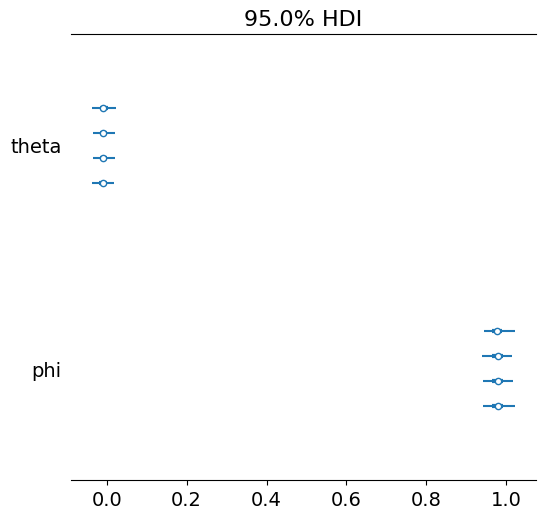

In [11]:
az.plot_forest(idata_HMC, var_names=["theta","phi"], combined=False, hdi_prob=0.95);
plt.show()

# Part 2 Another Column

In [12]:
exponential_lognormal = pm.Model()
with exponential_lognormal:
    #lam = pm.Gamma("lam", alpha=1, beta=1) 
    lam = pm.LogNormal("lam", mu=0, sigma=5)
    x_obs = pm.Exponential("likelihood", lam=lam,observed=df['Feature7'])

In [13]:
with exponential_lognormal:
    idata_HMC_NN = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


HMC Split-Rhats {'lam': 1.0019} | 

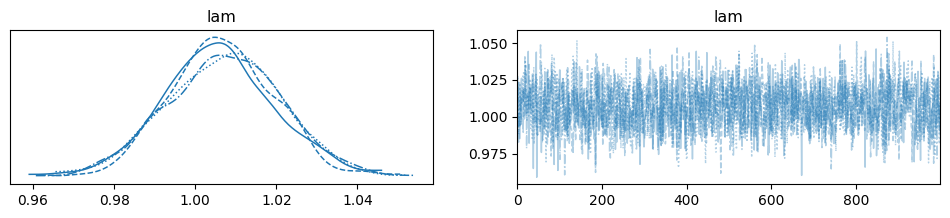

In [14]:
az.plot_trace(idata_HMC_NN); 
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC_NN).items()}, end=' | ');

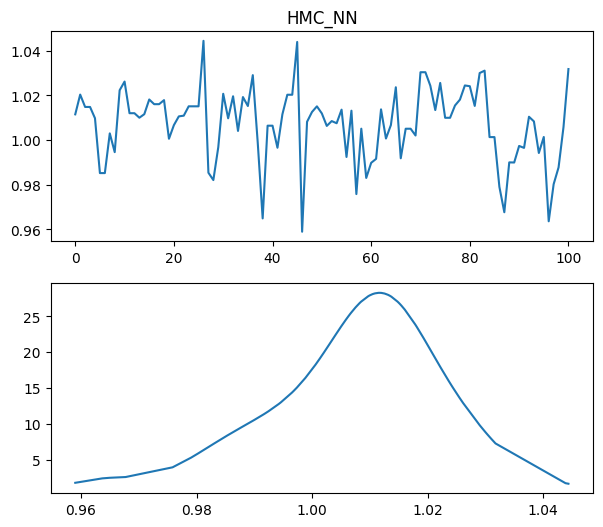

In [15]:
fig,ax = plt.subplots(2,1,figsize=(7,6))
n_mcmc_samples = 100
mcmc_chain = idata_HMC_NN.posterior["lam"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; 
mcmc_chain_sorted = sorted(mcmc_chain)
ax[0].plot(mcmc_chain); 
ax[1].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); 
ax[0].set_title("HMC_NN");

Autocorrelation for HMC (MCMC) chain 0.34736547604829043


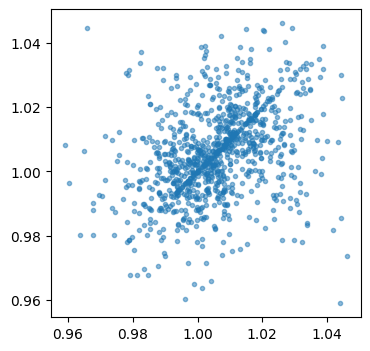

In [16]:
fig,ax = plt.subplots( figsize=(4,4))
max_mcmc_samples = 1000
mcmc_chain = idata_HMC_NN.posterior["lam"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; 
mcmc_chain_one_step_ahead = idata_HMC_NN.posterior["lam"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; 
plt.plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

In [17]:
print("number of MCMC samples:", idata_HMC_NN.posterior['lam'].values.flatten().shape[-1])
az.summary(idata_HMC_NN, round_to=2)

number of MCMC samples: 4000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lam,1.01,0.01,0.98,1.03,0.0,0.0,1885.78,2900.24,1.0


c:\Users\Matth\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
c:\Users\Matth\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


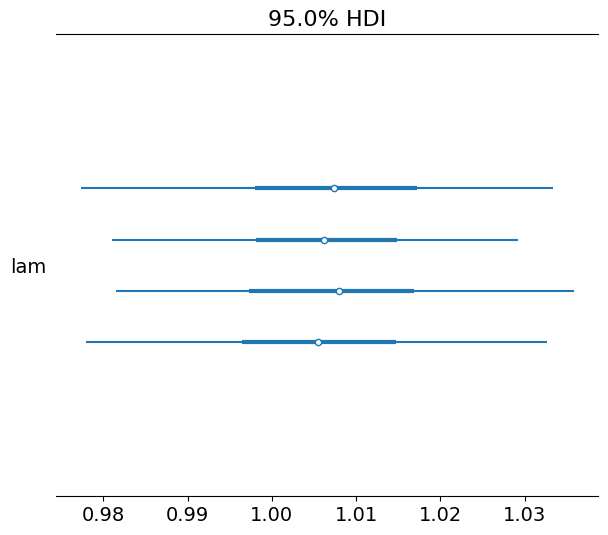

In [18]:
fig ,ax= plt.subplots(figsize=(7,6))
az.plot_forest(idata_HMC_NN, var_names=["lam"], combined=False, hdi_prob=0.95,ax=ax);
plt.show()